<a href="https://colab.research.google.com/github/visiont3lab/machine-learning-course/blob/main/classification/Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Project: Mask-NoMask Classifier

## Setup

In [ ]:
# Installare sklearn to onnx convertor
# http://onnx.ai/sklearn-onnx/
!pip install skl2onnx

# Installare onnxruntime
!pip install onnxruntime

In [ ]:
# Scaricare il repositorio da github per avere accesso alle immagini
!git clone https://github.com/visiont3lab/covid-mask-classifier.git

In [2]:
# Configurare il path di lavoro entrando nella cartella scaricata
%cd covid-mask-classifier/

/content/covid-mask-classifier


In [23]:
# Importare le librerie necessarie per il progetto
import os
import cv2 #opencv-python
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, auc,precision_score,recall_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import PCA
import ipywidgets as widgets
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report  
import pandas as pd

# Sklearn to Onnx
from skl2onnx import convert_sklearn  
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt

## Prepare data

### Intro a OpenCV: load,resize,color to gray options

In [ ]:

path_mask = os.path.join("dataset","mask")
path_nomask = os.path.join("dataset","no-mask")

names_mask = os.listdir(path_mask)
names_nomask = os.listdir(path_nomask)

i=0
for name in names_nomask:
    filename = os.path.join(path_nomask, name)
    im = cv2.imread(filename, cv2.IMREAD_COLOR)
    #im = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im, (64,64))
    #im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) #64*64
    cv2_imshow(im)
    #im = im / 255
    im_vec = im.flatten()
    #im_check = im_vec.reshape(64,64)
    im_check = im_vec.reshape(64,64,3)
    cv2_imshow(im_check)
    print(im_vec.shape)
    i=i+1
    if i==10:
        break

### Creare una funzione di caricamento dati

In [9]:
def load_data_class():
    # O Mask
    # 1 No Mask
    SIZE = (256,256) 
    X = []
    Y = [] # 0=Mask , 1=No Mask
    folders_path = ["dataset/mask/","dataset/no-mask/"]
    for folder_path in folders_path:
        names = os.listdir(folder_path)
        for name in names:
            # Read Image
            im = cv2.imread(folder_path+name,cv2.IMREAD_COLOR) # 1 cv2.IMREAD_COLOR, 0 cv2.IMREAD_GRAYSCALE
            # Resize Image
            im = cv2.resize(im,SIZE,interpolation=cv2.INTER_AREA)
            # Convert image to color
            im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY )
            # Normalization
            im = im / 255
            # Reshape image to vector
            vec = im.reshape(-1)
            # Create dataset
            X.append(vec)
            if folder_path == "dataset/mask/":
                Y.append(0)
            else:
                Y.append(1)
    # Creare array
    X = np.array(X,dtype="float32")  #--> 999 x 16384 (128*128)
    Y = np.array(Y,dtype="float32")
    return X, Y

X,Y = load_data_class()

### Considerazione: Se volessi ridurre il numero degli input? PCA

In [10]:
print(X.shape)
pca = PCA(n_components=0.99)
pca.fit(X)
X_new = pca.transform(X)
print(X_new.shape)

(999, 65536)
(999, 617)


## Data Augmentation

In [99]:
!rm -rf dataset-aug 
!mkdir -p dataset-aug/mask
!mkdir -p dataset-aug/no-mask

In [ ]:
#https://keras.io/api/preprocessing/image/
name_mask = "mask" # Da fare sia per "mask" che per "no_mask"
name_nomask = "no-mask" # Da fare sia per "mask" che per "no_mask"
folder_path = "dataset/" # da quale cartella vogliamo leggere
folder_path_augmented_mask = "dataset-aug/" + name_mask
folder_path_augmented_nomask = "dataset-aug/" + name_nomask


IMG_SIZE = (64,64) # W, H
BATCH_SIZE = 250
def my_generator_mask(batch_size):
    SEED=42  
    images_generator = ImageDataGenerator(
            #rescale=1./255,
            brightness_range=(0.3, 1.0),
            vertical_flip=False,
            horizontal_flip=True,
            width_shift_range=0.12, #0.05,
            height_shift_range=0.12, #0.05,
            rotation_range=10, #2,
            zoom_range=0.15
            ).flow_from_directory(
                directory=folder_path,
                classes=[name_mask],
                target_size=IMG_SIZE,
                color_mode="rgb", # grayscale
                batch_size=batch_size,
                class_mode="categorical",
                shuffle=True,
                seed=SEED
            )
        #.flow(logo, logo, batch_size, seed=SEED)
    while True:
        images_aug_batch,_ = images_generator.next()
        yield images_aug_batch  

def my_generator_nomask(batch_size):
    SEED=42  
    images_generator = ImageDataGenerator(
            #rescale=1./255,
            brightness_range=(0.3, 1.0),
            vertical_flip=False,
            horizontal_flip=True,
            width_shift_range=0.12, #0.05,
            height_shift_range=0.12, #0.05,
            rotation_range=10, #2,
            zoom_range=0.15
            ).flow_from_directory(
                directory=folder_path,
                classes=[name_nomask],
                target_size=IMG_SIZE,
                color_mode="rgb", # grayscale
                batch_size=batch_size,
                class_mode="categorical",
                shuffle=True,
                seed=SEED
            )
        #.flow(logo, logo, batch_size, seed=SEED)
    while True:
        images_aug_batch,_ = images_generator.next()
        yield images_aug_batch  

for j in range(0,2):
    images_aug_mask_batch  = next(my_generator_mask(BATCH_SIZE))
    images_aug_nomask_batch  = next(my_generator_nomask(BATCH_SIZE))
    print(images_aug_mask_batch.shape)
    for i in range(0,images_aug_batch.shape[0]):
        im_mask = cv2.cvtColor(images_aug_mask_batch[i,:,:,:], cv2.COLOR_BGR2RGB)
        im_nomask = cv2.cvtColor(images_aug_nomask_batch[i,:,:,:], cv2.COLOR_BGR2RGB)
        
        #im = cv2.cvtColor(images_aug_batch[i,:,:,:], cv2.COLOR_BGR2GRAY)
        cv2.imwrite(folder_path_augmented_mask + "/" + str(j) + "_" + str(i) + ".png", im_mask)
        cv2.imwrite(folder_path_augmented_nomask + "/" + str(j) + "_" + str(i) + ".png", im_nomask)
        im = cv2.resize(im_mask, (128,128))     
        cv2_imshow(im)
    

## Load Dataset

A questo punto possiamo scegliere se utilizzare il dataset aumentato oppure quello originale.

* Initial data: **folder_path = "dataset"**
* Data augmented: **folder_path = "dataset"**


In [101]:
def load_data():
    folder_path = "dataset-aug"
    #folder_path = "dataset"
    channel = 3
    size = 64

    ## -----------  Read Data
    class_name =  ["mask", "no-mask"]

    num_classes = len(class_name)
    X = []
    Y = []
    for i in range(0,num_classes):
        fpath = os.path.join(folder_path, class_name[i])
        for name in os.listdir(fpath):
            path_read_im = os.path.join(fpath, name)
            #print(path_read_im)
            im = None
            if channel==3: 
                im = cv2.imread(path_read_im,1) # COLOR
            else:
                im = cv2.imread(path_read_im,0) # GRAY

            im = cv2.resize(im, (size,size), interpolation = cv2.INTER_AREA)
            im = im.reshape(size*size*channel)

            X.append(im)
            Y.append(i)

    X = np.array(X, dtype="float32")
    Y = np.array(Y, dtype="float32")

    print(X.shape)
    print(Y.shape)
    return X,Y

X,Y = load_data()

(1000, 12288)
(1000,)


In [102]:
def compare_models(X,Y):
    # user variables to tune
    seed    = 5
    folds   = 5 # 10 = 10%, 5 = 20% for testing
    #5-fold cross validation. This means that 20% of the data is used for testing, this is usually pretty accurate.
    metric  ="roc_auc"

    sc = MinMaxScaler() # 0-1
    X = sc.fit_transform(X)
    print(X.shape)

    pca = PCA(n_components=0.99)
    X = pca.fit_transform(X)
    print(X.shape)

    # hold different regression models in a single dictionary
    models = {}
    models["GradientBoost"]        = GradientBoostingClassifier() #n_estimators=50)
    models["RandomForest"]         = RandomForestClassifier() #n_estimators=100)
    #models["NaiveBayes"]           = GaussianNB()
    #models["Logistic"]             = LogisticRegression()
    models["SVC"]                   = SVC(probability=True)

    # 10-fold cross validation for each model
    model_results = []
    model_names   = []
    for model_name in models:
        model   = models[model_name]
        k_fold  = KFold(n_splits=folds, random_state=seed,shuffle=True)
        results = cross_val_score(model, X, Y, cv=k_fold, scoring=metric)

        model_results.append(results)
        model_names.append(model_name)
        print("{}: {}, {}".format(model_name, round(results.mean(), 3), round(results.std(), 3)))

compare_models(X,Y)

(1000, 12288)
(1000, 280)
GradientBoost: 0.994, 0.007
RandomForest: 0.996, 0.004
SVC: 0.99, 0.007


In [103]:
# Saving Options (Pickle, Onnx)
def save_model_onnx(inp_name,inp_clf,sizeFlatten):
    # sizeFlatten = size*size*channel
    # Convert into ONNX format
    initial_type = [('float_input', FloatTensorType([None, sizeFlatten]))]
    onx = convert_sklearn(inp_clf, initial_types=initial_type)
    with open(inp_name, "wb") as f:
        f.write(onx.SerializeToString())

def save_model_pickle(inp_name,inp_clf):
    #https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn
    with open(inp_name, 'wb') as f:
        pickle.dump(inp_clf, f) 

def save_model_joblib(inp_name,inp_clf):
    joblib.dump(inp_clf, inp_name) 

def load_model_joblib(inp_name):
    # Load a pipeline
    my_model_loaded = joblib.load(inp_name)
    return my_model_loaded

def load_model_pickle(inp_name):
    with open(inp_name, 'rb') as f:
        model = pickle.load(f)
    return model

def load_model_onnx(inp_name):
    model_onnx_sess =  rt.InferenceSession(inp_name)
    return model_onnx_sess


# Training !
def train(X,Y):
    X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ("sc", MinMaxScaler()), # 0-1 features
        #('polinomial', PolynomialFeatures(degree=3)),
        ("pca", PCA(n_components=0.99)),
        ("model", SVC(probability=True) ) # Probability truw slow down dataset
    ])

    pipeline.fit(X_train,Y_train)
    score_train = pipeline.score(X_train,Y_train)
    score_test = pipeline.score(X_test,Y_test)
    print("f1_weighted score Train: ", score_train)
    print("f1_weighted score Test: ", score_test)

    save_model_joblib("model_pickle.pkl", pipeline)
    sizeFlatten = len(X_train[0])
    save_model_onnx("model_onnx.onnx",pipeline,sizeFlatten)
    return pipeline

    '''
    tuned_parameters = [
                {'model__kernel': ['rbf'],  'model__C': [1,10, 100, 1000]},
                {'model__kernel': ['linear'], 'model__C': [1, 10, 100, 1000]},
                #{'model__kernel' : ['poly'], 'model__degree' : [2,3,4] ,'model__C': [1,10, 100, 1000]}
            ]
    
    grid_search = RandomizedSearchCV(
        pipeline, tuned_parameters, scoring='f1_macro'
    )

    # Train
    grid_search.fit(X_train,Y_train)

    # Score
    score = grid_search.best_estimator_.score(X,Y)
    print("f1_weighted score : ", score)

    save_model_joblib("model.pkl", grid_search.best_estimator_)
    return grid_search.best_estimator_
    '''

def train_finetuning(X,Y):
    X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ("sc", MinMaxScaler()), # 0-1 features
        #('polinomial', PolynomialFeatures(degree=3)),
        ("pca", PCA(n_components=0.99)),
        ("model", SVC(probability=True) ) # Probability truw slow down dataset
    ])

    tuned_parameters = [
                {'pca__n_components': [0.97,0.98,0.99]},
                {'model__kernel': ['rbf'],  'model__C': [1,10, 100, 1000]},
                {'model__kernel': ['linear'], 'model__C': [1, 10, 100, 1000]},
                #{'model__kernel' : ['poly'], 'model__degree' : [2,3,4] ,'model__C': [1,10, 100, 1000]}
            ]
    
    grid_search = RandomizedSearchCV(
        pipeline, tuned_parameters, scoring='f1_macro'
    )

    # Train
    grid_search.fit(X_train,Y_train)

    # Score
    score = grid_search.best_estimator_.score(X,Y)
    print("f1_weighted score : ", score)

    save_model_joblib("model.pkl", grid_search.best_estimator_)
    return grid_search.best_estimator_
  

# Inference
class Inference:
  def __init__(self):
    self.model_pickle = self.load_model_pickle()
    self.model_onnx = self.load_model_onnx()
  
  def load_model_pickle(self):
    model = load_model_joblib("model_pickle.pkl")
    #model = load_model_pickle("model_pickle.pkl")
    return model

  def load_model_onnx(self):
    model_onnx_sess =  rt.InferenceSession("model_onnx.onnx")
    return model_onnx_sess

  def inference_pickle(self,X):
    Y_pred = self.model_pickle.predict(X)
    return Y_pred

  def inference_onnx(self,X):
    input_name = self.model_onnx.get_inputs()[0].name
    label_name = self.model_onnx.get_outputs()[1].name  # 0 output_label, 1 output_proability
    print(input_name, label_name)
    Y_pred = self.model_onnx.run([label_name], {input_name: X.astype(np.float32)})[0] # return a list of dick
    Y_pred_fin = []
    for val in Y_pred:
      mask_perc = val[0]
      nomask_perc = val[1]
      if mask_perc >= nomask_perc:
        Y_pred_fin.append(0)
      else:
        Y_pred_fin.append(1)
    return Y_pred_fin

def report(X,Y):
    Inf = Inference()

    Y_pred = Inf.inference_pickle(X)
    #Y_pred = Inf.inference_onnx(X)

    print("Confusion Matrix")
    cm = confusion_matrix(Y,Y_pred)
    df = pd.DataFrame(cm, columns=["Pred-Mask","Pred-No-Mask"], index=["Real-Mask","Real-No-Mask"])
    display(df)
    print("Report")
    print(classification_report(Y, Y_pred))

pipeline = train(X,Y)
#pipeline = train_finetuning(X,Y)
report(X,Y)

f1_weighted score Train:  0.99
f1_weighted score Test:  0.97
Confusion Matrix


,Pred-Mask,Pred-No-Mask
Real-Mask,492,8
Real-No-Mask,6,494


Report
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       500
         1.0       0.98      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



## Deploy / Production

Python webserver to deploy
* [Flask](https://flask.palletsprojects.com/en/1.1.x/)
* [Streamlit](https://www.streamlit.io/)
* [Tornado](https://www.tornadoweb.org/en/stable/)

Usando i modelli onnx è possibile utilizzare il modello allenato anche in ambiente **c#**

È anche possibile combinare python webserver (flask,tornado) con javascript framework come [VueJs](https://vuejs.org/) e [ReactJs](https://it.reactjs.org/)

In [49]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


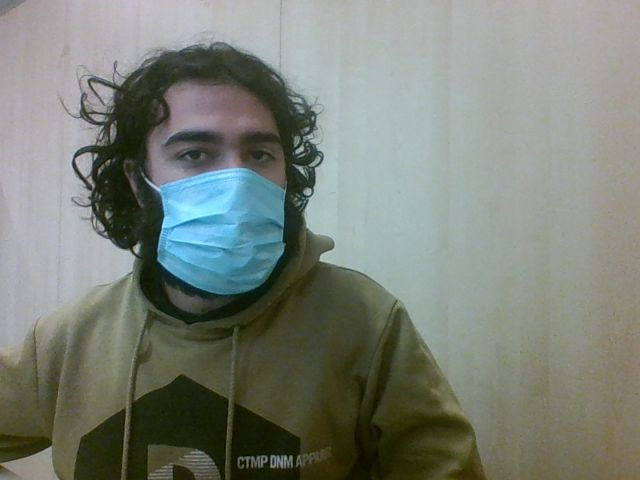

In [110]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [131]:
def load_model_joblib(inp_name):
    # Load a pipeline
    my_model_loaded = joblib.load(inp_name)
    return my_model_loaded

# Face detection
class FaceMaskDetector:
	
    def __init__(self):
        self.model_face = cv2.CascadeClassifier('models/haarcascade/haarcascade_frontalface_default.xml')
        self.model_mask = load_model_joblib("model_pickle.pkl")
        self.size = 64
        self.channel = 3

    def  findLargestBB(self,bbs):
      areas = [w*h for x,y,w,h in bbs]
      if not areas:
          return False, None
      else:
          i_biggest = np.argmax(areas) 
          biggest = bbs[i_biggest]
          return True, biggest

    def run(self, image):
        image_proc = image
        if self.channel==1:
            image_proc = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        faces = self.model_face.detectMultiScale(image,scaleFactor=1.1,minNeighbors=4, flags=cv2.CASCADE_DO_ROUGH_SEARCH | cv2.CASCADE_SCALE_IMAGE)
        isFaceDetected, face = self.findLargestBB(faces)
        if isFaceDetected:
          for (x,y,w,h) in [face]:
          #for (x,y,w,h) in faces: 
              #print("Face found")
              roi = image_proc[y:y+h,x:x+w]
              # HA oppure non  ha la mascherina
              roi_resized = cv2.resize(roi,( self.size , self.size ))
              #print(roi_resized.shape)
              #roi_resized = roi_resized[np.newaxis,:,:,:]
              vec = roi_resized.reshape(1,self.size*self.size*self.channel)
              print(vec.shape)
              res = self.model_mask.predict_proba(vec)  
              #print(res.shape)          
              mask_perc = res[0][0]
              #no_mask_perc = res[0][1]
              print( "Mask: " + str(np.round(mask_perc,1)) )

              #cv2.imwrite(self.save_folder+str(self.c)+".png", roi)
              cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
              cv2_imshow(image)
            
    def run_roi(self, roi):
        # HA oppure non  ha la mascherina
        roi_resized = cv2.resize(roi,(self.size,self.size))
        #print(roi_resized.shape)
        roi_resized = roi_resized[np.newaxis,:,:,:]
        #print(roi_resized.shape)
        vec = roi_resized.reshape(1,self.size*self.size*self.channel)
        #print(vec.shape)
        res = self.model_mask.predict_proba(vec)  
        #print(res.shape)          
        mask_perc = res[0][0]
        #no_mask_perc = res[0][1]
        print( "Mask: " + str(np.round(mask_perc,1)) )
        cv2_imshow(roi)

class FaceMaskDetectorDeep:
	
    def __init__(self):
        prototxtPath = os.path.join("models","mobilenet", "deploy.prototxt")
        weightsPath = os.path.join("models","mobilenet","res10_300x300_ssd_iter_140000.caffemodel")
        self.net = cv2.dnn.readNet(prototxtPath, weightsPath)
        self.confidence = 0.4
        self.model_mask = load_model_joblib("model_pickle.pkl")
        self.size = 64
        self.channel = 3

    def run(self, image):
        orig = image.copy()
        (h, w) = image.shape[:2]

        blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
        self.net.setInput(blob)
        detections = self.net.forward()

        for i in range(0, detections.shape[2]):
            # extract the confidence (i.e., probability) associated with  the detection
            confidence = detections[0, 0, i, 2]

            # filter out weak detections by ensuring the confidence is
            # greater than the minimum confidence
            if confidence > self.confidence:
                # compute the (x, y)-coordinates of the bounding box for
                # the object
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                x = startX
                y= startY
                w = endX-startX
                h = endY -startY

                # ensure the bounding boxes fall within the dimensions of
                # the frame
                #(startX, startY) = (max(0, startX), max(0, startY))
                #(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

                # extract the face ROI, convert it from BGR to RGB channel
                # ordering, resize it to 224x224, and preprocess it

                roi = image[y:y+h,x:x+w]

                # HA oppure non  ha la mascherina
                roi_resized = cv2.resize(roi,(self.size,self.size))
                #print(roi_resized.shape)
                roi_resized = roi_resized[np.newaxis,:,:,:]
                #print(roi_resized.shape)
                vec = roi_resized.reshape(1,self.size*self.size*self.channel)
                #print(vec.shape)
                res = self.model_mask.predict_proba(vec)  
                #print(res.shape)          
                mask_perc = res[0][0]
                #no_mask_perc = res[0][1]
                print( "Mask: " + str(np.round(mask_perc,1)) )

                #cv2.imwrite(self.save_folder+str(self.c)+".png", roi)
                cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
                cv2_imshow(image)


(1, 12288)
Mask: 1.0


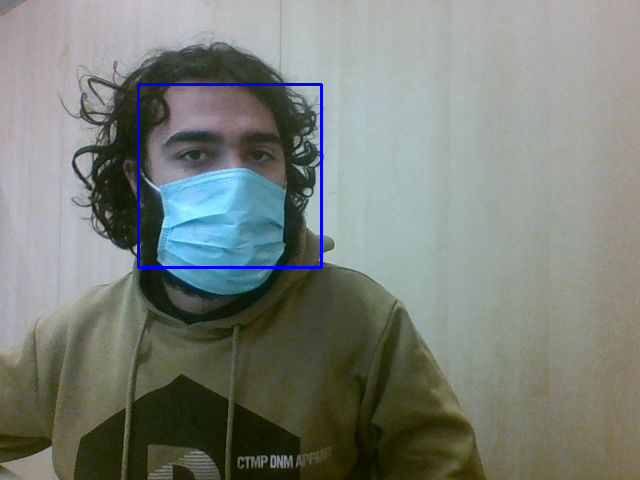

In [132]:
cf = FaceMaskDetector()
im = cv2.imread("photo.jpg",cv2.IMREAD_COLOR)
cf.run(im)

Mask: 1.0


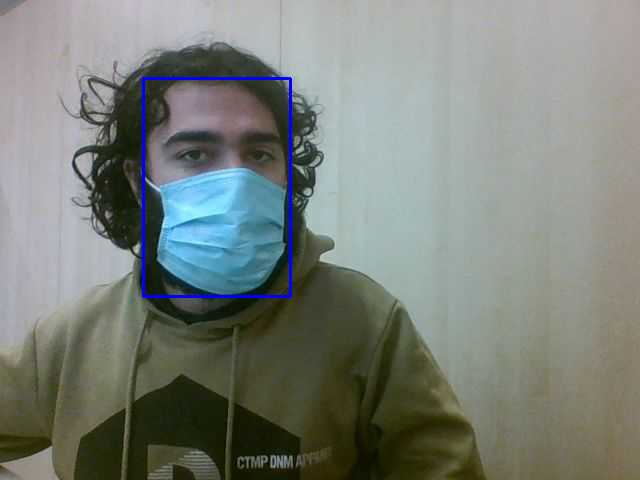

In [133]:
# Improvement haar cascade
cf = FaceMaskDetectorDeep()
im = cv2.imread("photo.jpg",1)
cf.run(im)

## Teoria

## Teoria
Quando parliamo di classificazione binaria possiamo avere quattro possibili risultati.
  * TN True Negative
  * TP True Positive
  * FN False Negative
  * FP False Positive

| Risultato Esatto   | Risulato Predetto |  |
|------------|---------------------------|--|
|            |   Negativo | Positivo |
|Negativo    |    TN      |    FP    |
|Positivo    |    FN      |    TP    |

### Metriche

* Accuracy: $\frac{TP+TN}{TP+TN+FP+FN}$

Proportion of correct classifications (true positves and negatives) from overall number of cases.

  Quante volte il nostro algoritmo ha predettto il risultato giusto? Sarebbe quante volte il classifcatore ha predetto vero ed era vero o a predetto falso ed era falso.

* Recall or Sensitivity: $\frac{TP}{TP+FN}$

Proportion of correct positive classifications (true positives) from cases that are actually positive.

  Quante volte il classificatore ha predetto vero ed era vero diviso lo stesso più quante volte il classificatore ha predetto falso ma in realtà era vero. La recall mi da la percentuale di quanto il mio algorimo ha risposto vero. Quante volte l'algorimo ha predetto che non era 5 ma in realtà lo era (in percentuale)? Percentuale di  volte che ho riconosciuto che era 5 rispetto a quante volte ho detto che non era 5 ma lo era.

* Precision: $\frac{TP}{TP+FP}$ 

Proportion of correct positive classifications (true positives) from cases that are predicted as  positive.

  Percentuale che rappressenta la frazione tra quante valte l'algoritmo ha predetto vero ed era vero diviso lo stesso più quante volte l'algoritmo ha preddeto vero ma in realtà era falso. Nel nostro esempio quante volte l'algoritmo ha predetto 5 ma in realtà non lo era (in percentale)? Percentuale di  volte che ho riconosciuto che era 5 rispetto a quante volte ho detto che era 5 ma non lo era.


Esempio:

| Risultato Esatto   | Risulato Predetto |  |
|------------|---------------------------|--|
|            |   Negativo | Positivo |
|Negativo    |    TN=97750     |    FP=150    |
|Positivo    |    FN=330      |    TP=1770    |



* Accuracy = $\frac{TP+TN}{TP+TN+FP+FN} = \frac{1770+97750}{100000}=0.9952$

* Recall = $\frac{TP}{TP+FN} = \frac{1770}{1770+330}=0.8428$

* Precision = $\frac{TP}{TP+FP} = \frac{1770}{1770+150}=0.9219$

È un modello buono?

Recall: percetuale di sbaglio dell'algoritmo nel predirre 5. 1 - 0.84 = 0.26%
Quanto l'algoritmo sbaglia nel dare come risulta che il numero è 5. 
Voglio essere sicuro che tutte le volte che un numero è 5 io (classifier) lo riconosca come 5.

Precision:Quanto l'algoritmo sbaglia nel dare come risulta che il numero non è 5
Voglio essere sicuro che tutte le volte che un numero no è 5 (classifier) io lo riconosca come NON 5.

Quindi possiamo concludere che il modello che abbiamo sarà ottimo nel riconoscere che in numero non è 5 (Precision=92%) mentre invece non sarà granche nel dire che il numero è 5 (Recall=84%)

Tumori:
Recall 95%: se vedo il tumore X lo riconosco al 95%. Quindi ho una bassa probabilità di di dire che "X" non è un tumore quando il realtà lo è.
Prcecision 60%: se vedo X ed non è un tumore ho una percentuale alta 40% di dire chè lo è. Cioè ho una probabilità alta di sbagliarmi sul fatto che un un X non è un tumore e per me lo è. (Diciamo che tendo un po a dire che tutto è tumore per non sbagliare) 

## Extra: Disegnare un retangolo nell'immagine in posizione fissa

(1, 12288)


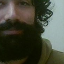

[0.]
[[0.88827154 0.11172846]]


'\nx = 250\ny = 160\nw = 180\nh = 180\ncv2.rectangle(im,(x,y),(x+w,y+h),(255,0,0),2)\nroi = im[y:y+h,x:x+w]\n#cv2_imshow(im)\ncf = FaceMaskDetector()\ncf.run_roi(roi)\n'

In [87]:
im = cv2.imread("photo.jpg",1)
x = 250
y = 200
w = 180
h = 180
#cv2.rectangle(im,(x,y),(x+w,y+h),(255,0,0),2)
roi = im[y:y+h,x:x+w]


model = load_model_joblib("model_pickle.pkl")
#roi = cv2.cvtColor(roi,cv2.COLOR_RGB2GRAY)
roi = cv2.resize(roi, (64,64))
roi_vec = roi.reshape(1,-1)
print(roi_vec.shape)
cv2_imshow(roi)
label = model.predict(roi_vec)
print(label)
res = model.predict_proba(roi_vec)
print(res)    



'''
x = 250
y = 160
w = 180
h = 180
cv2.rectangle(im,(x,y),(x+w,y+h),(255,0,0),2)
roi = im[y:y+h,x:x+w]
#cv2_imshow(im)
cf = FaceMaskDetector()
cf.run_roi(roi)
'''

## Extra: Use Goole colab with google drive

1. Cliccare sult bottone  **mount drive** (sotto la scritte **Files**. In alternativa potete copiare il seguente codice equivalente a premere il bottone.
```
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive
```

2. Una volta apparso drive nel file manager trovere disponibili tutti file che avete in google drive. Create una cartella in drive chiamata **Classification-Project** e configurate il path di lavoro scrivendo.
```
%cd /content/drive/My Drive/Classification-Project
```
Questo comando vi permetterà di lavorare all'interno della cartella drive usando google colab.

## Extra: Create a widget button to load a dataset

> Importante: È necessario eseguire le celle nel blocco setup prima di queste.

In [8]:
# Create a function able to load image: Use 
def load_data_class(obj):
    # O Mask
    # 1 No Mask
    SIZE = (128,128) 
    X = []
    Y = [] # 0=Mask , 1=No Mask
    folders_path = ["dataset/mask/","dataset/no-mask/"]
    for folder_path in folders_path:
        names = os.listdir(folder_path)
        for name in names:
            # Read Image
            im = cv2.imread(folder_path+name,cv2.IMREAD_COLOR) # 1 cv2.IMREAD_COLOR, 0 cv2.IMREAD_GRAYSCALE
            # Resize Image
            im = cv2.resize(im,SIZE,interpolation=cv2.INTER_AREA)
            # Convert image to color
            im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY )
            # Normalization
            im = im / 255
            # Reshape image to vector
            vec = im.reshape(-1)
            # Create dataset
            X.append(vec)
            if folder_path == "dataset/mask/":
                Y.append(0)
            else:
                Y.append(1)
    # Creare array
    X = np.array(X,dtype="float32")  #--> 999 x 16384 (128*128)
    Y = np.array(Y,dtype="float32")
    print(X.shape, Y.shape)
    #return X, Y

#X,Y = load_data_class()
btn = widgets.Button(
    description='Load data',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
btn.on_click(load_data_class)
display(btn)

Button(button_style='info', description='Load data', icon='check', style=ButtonStyle(), tooltip='Click me')

(999, 16384) (999,)
